In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure, save_factory, PlotConfig, format_plots, ONTOGENY_AGE_CMAP, add_identity, legend

In [2]:
format_plots()
c = PlotConfig()

In [3]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
n=16
df = df.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
# arrange data
data = df.astype(float, errors='ignore')
usage_mtx= filter_df(data)
data_labels = usage_mtx.index.get_level_values('age').to_numpy()

In [6]:
from sklearn.decomposition import PCA

In [7]:
latents = PCA(n_components=2).fit_transform(usage_mtx)

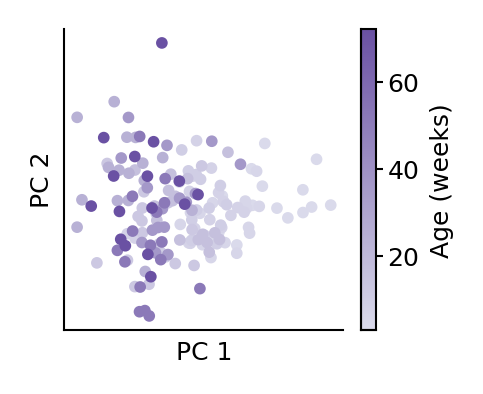

In [8]:
fig = figure(1.5, 1.3)
ax = fig.gca()
im = ax.scatter(*latents.T, c=usage_mtx.index.get_level_values('age'), cmap=ONTOGENY_AGE_CMAP, s=4)
ax.set(xlabel='PC 1', ylabel='PC 2', xticks=[], yticks=[])
fig.colorbar(im, label="Age (weeks)")
sns.despine()
#saver(fig, 'pca-usage-ontogeny-males');

In [9]:
corr = pd.DataFrame({'pc1': latents[:, 0], 'age': usage_mtx.index.get_level_values('age')}).corr(method='spearman').loc['pc1', 'age']

In [10]:
corr

-0.6870823961656821

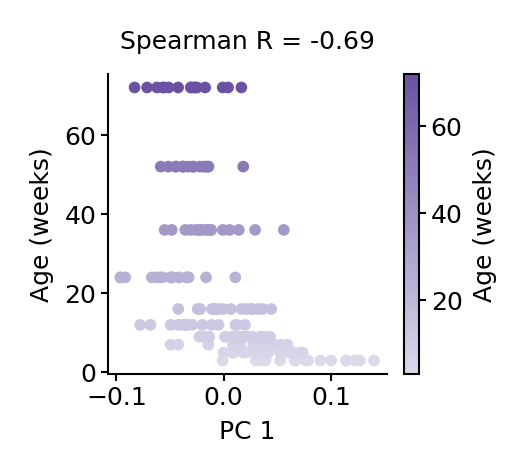

In [11]:
fig = figure(1.5, 1.3)
ax = fig.gca()
im = ax.scatter(latents[:, 0], usage_mtx.index.get_level_values('age'), c=usage_mtx.index.get_level_values('age'), cmap=ONTOGENY_AGE_CMAP, s=4)
sns.despine()
ax.set(xlabel='PC 1', ylabel='Age (weeks)', title=f'Spearman R = {corr:.2f}')
fig.colorbar(im, label="Age (weeks)")
#saver(fig, 'pc-vs-age-ontogeny-males');

In [12]:
pca = PCA().fit(usage_mtx)

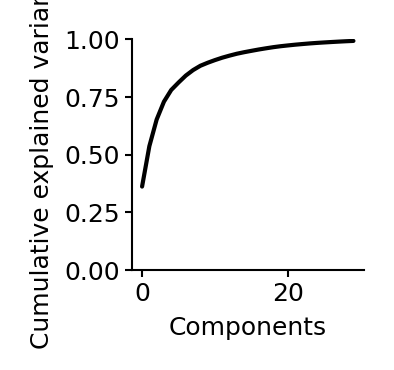

In [13]:
fig = figure(1, 1)
ax = fig.gca()
ax.plot(np.cumsum(pca.explained_variance_ratio_)[:30], color='k')
ax.set(xlabel='Components', ylabel='Cumulative explained variance', ylim=(0, 1))
sns.despine()
#saver(fig, 'pca-cumulative-variance');

In [14]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, GridSearchCV, GroupKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge

In [15]:
y = usage_mtx.index.get_level_values('age')
# x = pd.concat([usage_mtx[keep_sylls], np.log(usage_mtx[keep_sylls] + 1e-6)], axis=1)
x = usage_mtx.copy()

In [16]:
pipeline = make_pipeline(StandardScaler(), PCA(), KernelRidge(kernel='poly', alpha=0.63, degree=3, gamma=0.01))

In [17]:
cv = GridSearchCV(
    pipeline,
    param_grid={
        "pca__n_components": range(2, 25),
        "kernelridge__alpha": np.logspace(-2, 2, 21),
        "kernelridge__gamma": np.logspace(-3, 1, 21),
        "kernelridge__degree": range(2, 4),
        "kernelridge__kernel": ["poly", "rbf"],
    },
    cv=GroupKFold(n_splits=4),
    n_jobs=-1,
)

cv.fit(x, y, groups=y)

KeyboardInterrupt: 

In [ ]:
cv.best_params_

In [ ]:
cv.best_score_

In [ ]:
pipeline = make_pipeline(StandardScaler(), KernelRidge(kernel='poly', alpha=0.63, degree=3, gamma=0.01))
# pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=5))
preds = cross_val_predict(pipeline, x, y, groups=y, cv=LeaveOneGroupOut(), n_jobs=-1)
r2_score(y, preds)

In [ ]:
preds = cross_val_predict(cv.best_estimator_, x, y, groups=y, cv=LeaveOneGroupOut(), n_jobs=-1)
r2_score(y, preds)

In [ ]:
fig = figure(1.5, 1.5)
ax = fig.gca()
im = ax.scatter(y, preds, c=y, cmap=ONTOGENY_AGE_CMAP, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
fig.colorbar(im, label="Age (weeks)")
ax.set(xlabel='True age (weeks)', ylabel='Predicted age (weeks)', title=f'R2 = {r2_score(y, preds):.2f}', aspect='equal')
sns.despine()
#saver(fig, 'ontogeny-age-regression');

In [ ]:
residuals = pd.Series(y - preds, index=usage_mtx.index)

In [ ]:
plt.plot(residuals.values)
plt.ylabel('Residuals (weeks)')

## Aging dynamics using GP smoothing

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from toolz import valmap, keyfilter

In [19]:
age_scaler = StandardScaler()
x = usage_mtx.index.get_level_values("age")
x = age_scaler.fit_transform(x.to_numpy()[:, None])
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

In [20]:
kernel = 1 * RBF(length_scale=5e2, length_scale_bounds=(1e-3, 1e3))

out = {}
grads = {}

index = pd.Index(age_scaler.inverse_transform(time).squeeze(), name="age")

r2_scores = {}

for syll in tqdm(usage_mtx.columns.to_numpy()):
    y = usage_mtx[syll]
    gp = GaussianProcessRegressor(
        kernel=kernel, n_restarts_optimizer=5, alpha=1.125, normalize_y=True
    )
    gp.fit(x, y)
    r2_scores[syll] = gp.score(x, y)
    grads[syll] = np.gradient(gp.predict(time), time.squeeze())
    out[syll] = pd.Series(gp.predict(time), index=index, name="Predicted usage")

  0%|          | 0/40 [00:00<?, ?it/s]

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [21]:
score_thresh = 0.2
# drop_sylls = [29, 47]
#drop_sylls = [29, 47, 37, 66, 67]
drop_sylls=[]
keep_grads = keyfilter(lambda k: (r2_scores[k] > score_thresh) and (k not in drop_sylls), grads)

<Axes: xlabel='age', ylabel='5'>

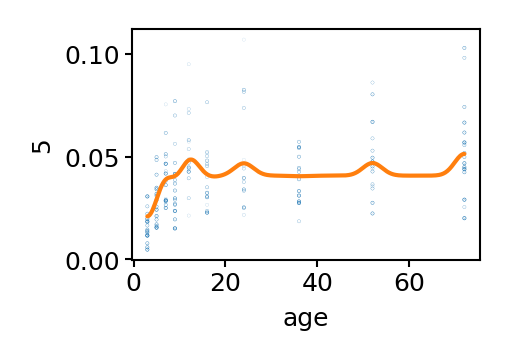

In [22]:
fig = figure(1.5, 1)
ax = fig.gca()
usage_mtx.reset_index().plot(kind='scatter', y=usage_mtx.columns.to_numpy()[0], x='age', s=10, ax=ax)
out[usage_mtx.columns.to_numpy()[0]].plot(ax=ax, c='C1')

In [23]:
# for k, v in keep_grads.items():
#     v[np.abs(v) > 0.07] = np.mean(v[np.abs(v) < 0.07])

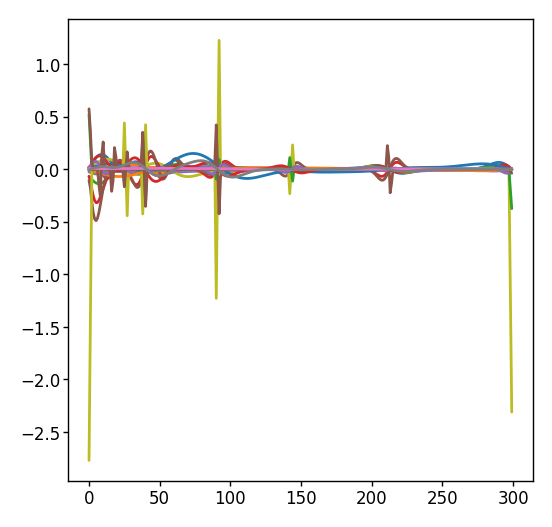

In [24]:
for k, v in keep_grads.items():
    plt.plot(v, label=k)

/n/groups/datta/win/longtogeny/code/aging/plotting.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  return plt.figure(figsize=(width, height), dpi=dpi, **kwargs)


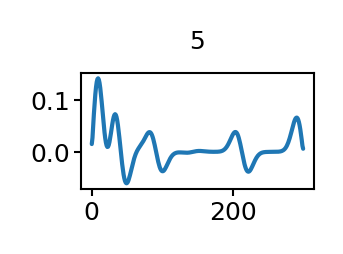

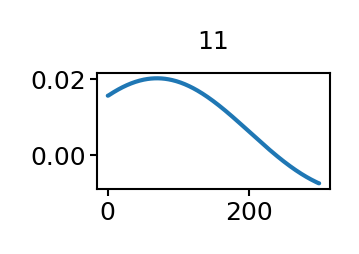

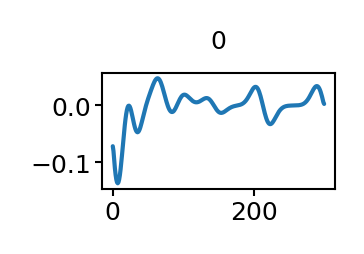

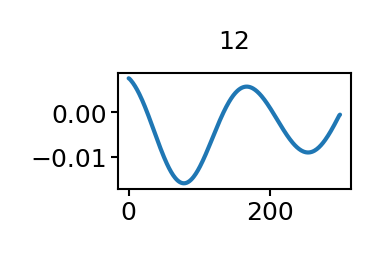

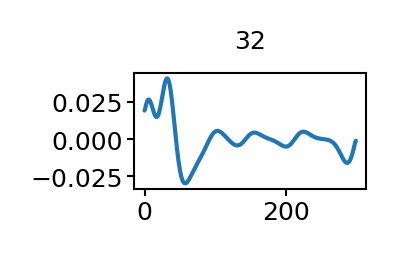

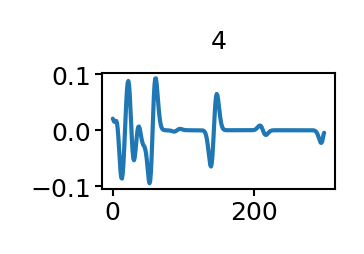

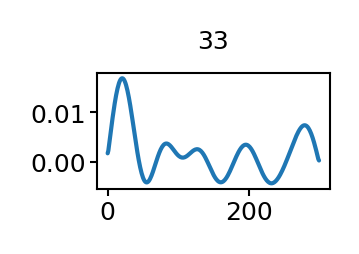

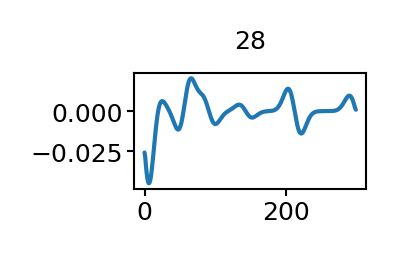

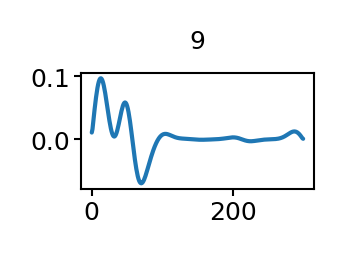

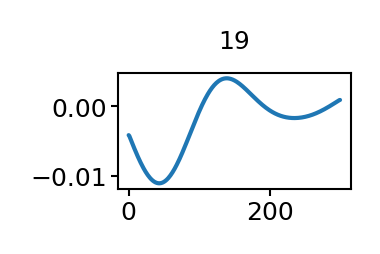

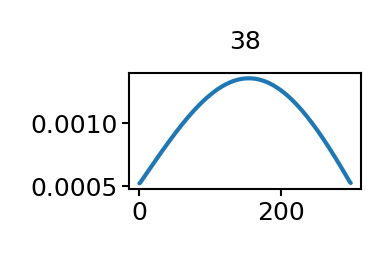

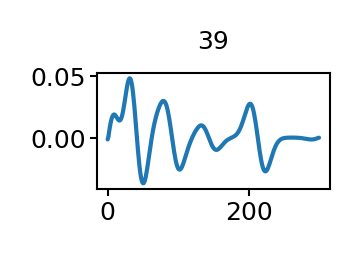

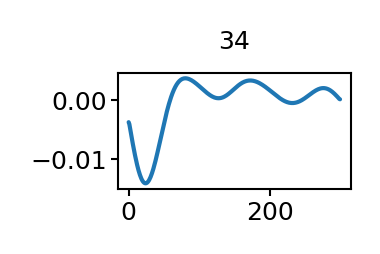

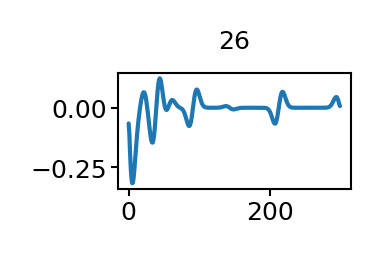

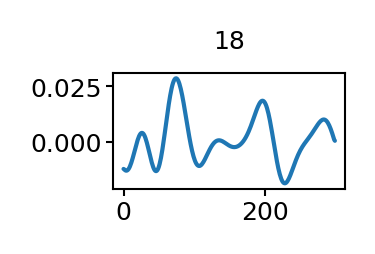

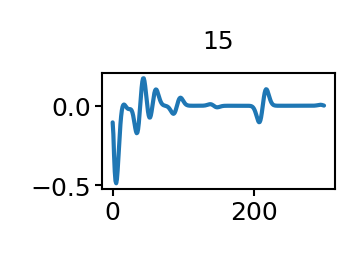

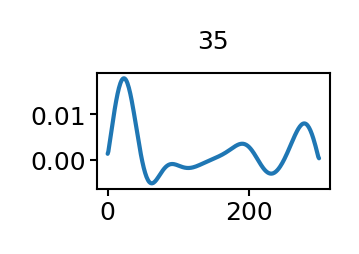

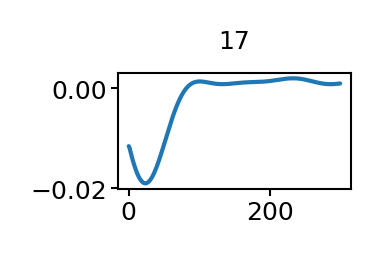

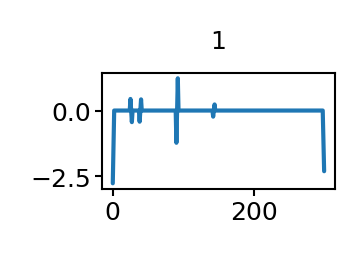

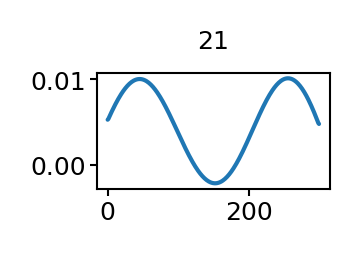

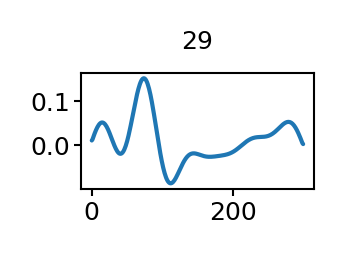

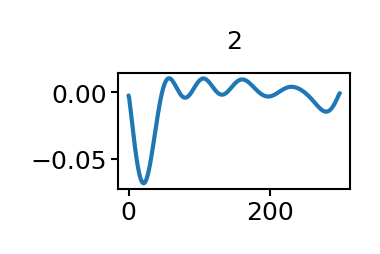

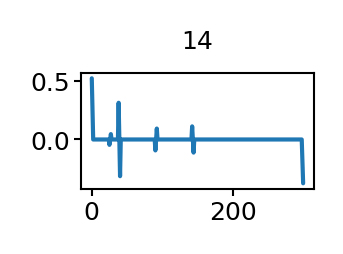

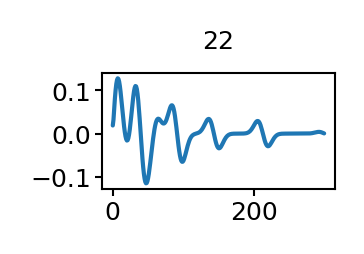

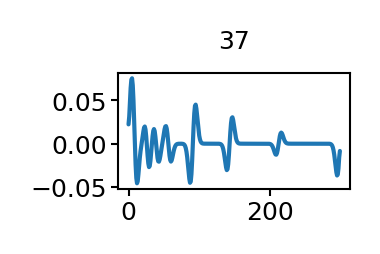

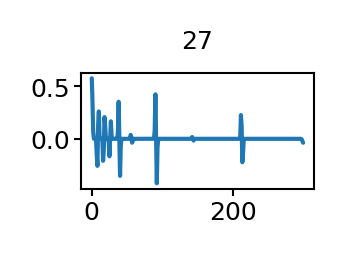

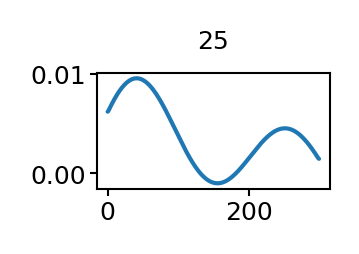

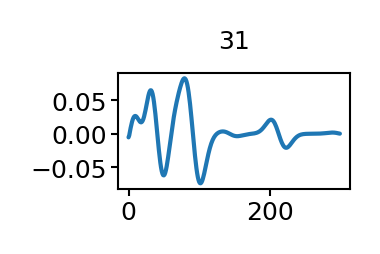

In [25]:
for k, v in keep_grads.items():
    figure(1, 0.5)
    plt.plot(v)
    plt.title(k)

In [26]:
grad_array = np.array(list(keep_grads.values()))

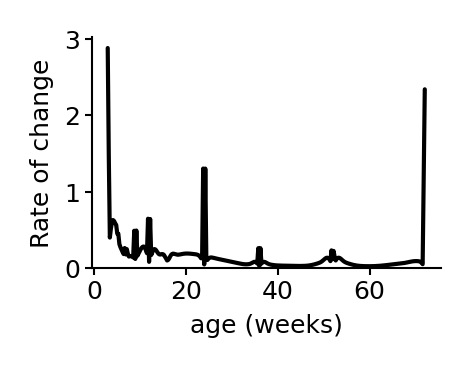

In [27]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time), np.linalg.norm(grad_array, axis=0), c='k')
plt.ylabel("Rate of change", fontsize=6)
plt.xlabel('age (weeks)')
plt.ylim(0, None)
sns.despine()
# saver(fig, "ontogeny-syllable-rate-of-change");

## Cluster syllable usage

In [28]:
from sklearn.cluster import KMeans

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 [Index([20, 7, 23, 26, 15, 1, 24], dtype='int64')]
Cluster 1 [Index([5, 11, 33, 28, 9, 38, 39, 18, 35, 36, 21, 29, 14, 22, 27, 6, 25, 31], dtype='int64')]
Cluster 2 [Index([0, 3, 12, 32, 13, 4, 19, 34, 17, 8, 16, 2, 37, 10, 30], dtype='int64')]


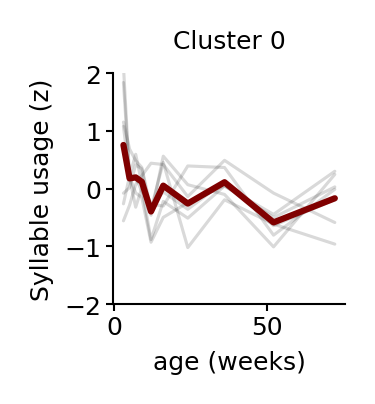

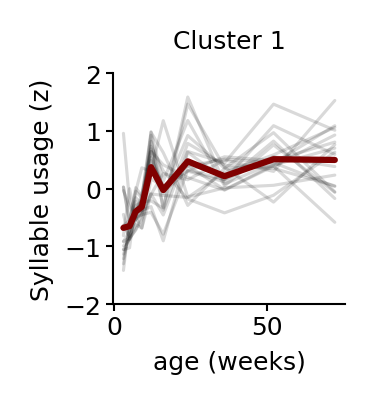

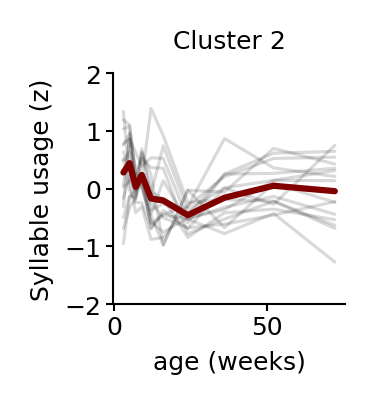

In [29]:
n_clusters = 5
clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(StandardScaler().fit_transform(usage_mtx).T)
scaled_df = pd.DataFrame(StandardScaler().fit_transform(usage_mtx), index=usage_mtx.index, columns=usage_mtx.columns.to_numpy())
for i in range(n_clusters):
    fig = figure(1, 1)
    tmp = scaled_df.iloc[:, clusters == i].groupby('age').mean()
    print(f'Cluster {i}', [tmp.columns])
    plt.plot(tmp, c='k', lw=0.75, alpha=0.15)
    plt.plot(tmp.mean(1), c='maroon', lw=1.5)
    plt.title(f'Cluster {i}')
    plt.xlabel('age (weeks)')
    plt.ylabel('Syllable usage (z)')
    plt.ylim([-2,2])
    sns.despine()
    #saver(fig, f'ontogeny-syllable-cluster-{i}')